# Coupled flow/viscous flexure ice shelf model
This notebook couples a slightly modified SSA [(MacAyeal et al., 2021)](https://www.cambridge.org/core/journals/journal-of-glaciology/article/treatment-of-iceshelf-evolution-combining-flow-and-flexure/AD266BB055752B4DC817FEAAA86363A3) with the viscous bending of a thin plate, allowing the approach of a steady-state ice shelf profile under both horizontal viscous flow and vertical viscous deflection. Equations are solved using Firedrake and [icepack](https://github.com/icepack/icepack). Beginning with a shelf in isostatic equilibrium with seawater, the workflow is as follows:

## Workflow

1) **Solve the SSA to obtain a velocity field**
    - this is the modified version from Equation 44 in MacAyeal et al. 
    - see also my [modified SSA notebook](https://github.com/chrismiele/weird_flex/blob/main/0_modified_SSA_firedrake.ipynb)<br>
    <br>
2) **Adjust the surface elevation and basal elevation via dynamic thinning only**
    - adjust shelf geometry under *zero surface mass balance* (the balance rate $\dot{B}$ will be applied in Step 4)
    - dynamically thin the submarine and subaerial parts of the shelf separately
    - this allows us to track the dynamic evolution of surface and basal elevation without assuming equilibrium <br>
    <br>
3) **Solve the viscous Kirchhoff equations to flex the shelf**
    - load relates to surface mass balance and velocity field as outlined in Eq. 57 of MacAyeal et al.
    - see also my [viscous Kirchhoff plate notebook](https://github.com/chrismiele/weird_flex/blob/main/2_kirchhoff_plate_viscous.ipynb)
    - in this step, we obtain the vertical deflection rate $\dot{η}$ <br>
    <br>
4) **Adjust geometry over timestep Δt and return to (1)**
    - now use $\dot{B}$ and $\dot{η}$ to modify surface elevation, via ```s = s + BΔt + ηΔt```
    - with no basal mass balance component, ```b = b + ηΔt```

## Imports

In [1]:
from firedrake import *
import icepack
from icepack.calculus import sym_grad
import matplotlib.pyplot as plt
import matplotlib.colors as colors 
import numpy as np
from operator import itemgetter
import os
import tqdm #displays progress bars in long-running loops

## Mesh, function spaces, trial and test functions

The shelf will be rectangular, with length ```Lx``` and width ```Ly```. Deflection will be solved over Argyris elements of order 5, and velocity will be solved over CG elements of order 2. 

In [2]:
nx, ny = 50, 25 #number of elements in x, y
Lx, Ly = 10000, 5000 #length, width in meters
mesh = RectangleMesh(nx, ny, Lx, Ly)
x, y = SpatialCoordinate(mesh)

Q1 = FunctionSpace(mesh, 'Argyris', 5) #Argyris elements for solving 4th order flexure problem
Q2 = FunctionSpace(mesh, 'CG', 2) #CG elements for icepack's prognostic solve, which does not appreciate Argyris elements
V = VectorFunctionSpace(mesh, 'CG', 2)  #CG elements for solving SSA problem
S = TensorFunctionSpace(mesh, 'DG', 1) #DG elements for interpolating tensors arising from the velocity field

η = Function(Q1) #deflection
w = TestFunction(Q1)
ddη = grad(grad(η)) 
ddw = grad(grad(w))
Δη = div(grad(η)) 
Δw = div(grad(w)) 

u = Function(V) #velocity
v = TestFunction(V) #note the Roman v, not to be confused with Greek ν introduced below

## Physical constants, shelf geometry

In [3]:
from icepack.constants import ice_density as ρ_I, water_density as ρ_W, gravity as G #note icepack's units on these
from icepack.constants import year #number of seconds in a year
ρ_i = 917 #ice density value consistent with icepack's, but in kg/m^3
ρ_w = 1024 #water density consistent with icepack, but in kg/m^3
ϱ = ρ_i/ρ_w #density ratio
g = 9.81 #gravity in N/kg
T = Constant(273.15) #temperature (K). 273.15 is freezing
A = icepack.rate_factor(T) #A from Glen's law

H_gl = 600 #thickness at upstream boundary (m)
thick_grad = 0 #thickness gradient 
H0 = project(H_gl + thick_grad*x, Q2) #initial thickness projected onto CG elements
b0 = project(-ϱ*H0, Q2) #initial basal elevation
s0 = project(H0 + b0, Q2) #initial surface elevation

## Modify some icepack modules to solve non-equilibrium SSA

Unlike the classic SSA, this variation does not assume the shelf to be exactly at flotation. We'll tweak icepack's ```gravity``` and ```terminus``` modules to allow the driving stress and terminal cliff boundary condition to reflect this departure from equilibrium. 

In [4]:
def gravity2(**kwargs): #see RHS of Eq. 44 in MacAyeal et al. (2021)
    u, h, b = itemgetter('velocity', 'thickness', 'base')(kwargs)
    return -0.5* ρ_I*G*inner(grad(h**2), u) + 0.5*ρ_W*G* inner(grad(b**2), u)

def terminus2(**kwargs): #see Eq. 45 from MacAyeal et al. (2021)
    u, h, b = itemgetter('velocity', 'thickness', 'base')(kwargs)
    mesh = u.ufl_domain()
    ν = FacetNormal(mesh)
    return 0.5*ρ_I*G*h**2*inner(u, ν) - 0.5*ρ_W*G*b**2*inner(u, ν)

def deviatoric_stress(**kwargs): #and also define the deviatoric stress tensor
    n = 3
    e = itemgetter('strain_rate')(kwargs)
    e_min = Constant(kwargs.get('strain_rate_min', icepack.constants.strain_rate_min))
    e_e = icepack.models.viscosity._effective_strain_rate(e, e_min)
    ν = 1/2*A**(-1/n)*e_e**(1/n-1)*1e6 
    return 2*ν*e #deviatoric stress tensor in Pascals

## Set up the solver

We'll apply the flow-flexure model to the simplest case of a shelf in longitudinal extension. This is achieved by assigning the lateral boundaries in the flow solver to be ```side_wall_ids``` with friction coefficient zero. 

To provide a load for the flexure solver, surface mass balance is chosen to melt out a lake in the shape of a Gaussian curve (see figure below). 

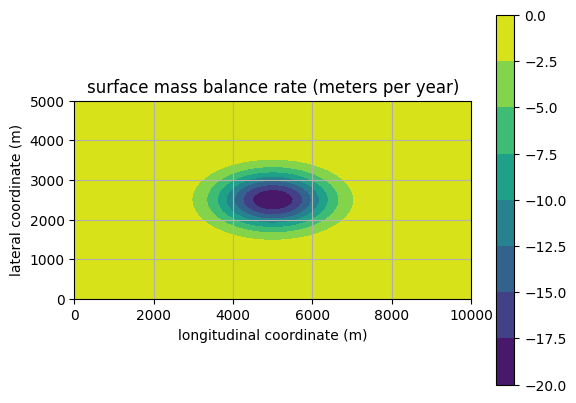

In [5]:
################################
################################
### parameters for iteration ###
################################
################################

Δt = 0.5 #length of timestep in years
num_timesteps = 40

##################################
##################################
### parameters for flow solver ###
##################################
##################################

dirichlet_ids = [1] #boundaries are labeled (1, 2, 3, 4) = (upstream, downstream, left, right)
side_wall_ids = [3, 4]
ice_front_ids = [2]

ux_gl = 500 #upstream boundary boundary condition in meters per year
u0 = project(as_vector([ux_gl, 1e-50]), V) #initial velocity (u_x, u_y) for imposing Dirichlet BCs

C0 = Constant(0.00) #coefficient of sidewall friction

model = icepack.models.IceShelf(gravity = gravity2, terminus = terminus2, #model is icepack's SSA, but with our own physics
                           side_friction = icepack.models.friction.side_friction)

solver = icepack.solvers.FlowSolver(model, dirichlet_ids = dirichlet_ids, 
                                    side_wall_ids = side_wall_ids, ice_front_ids = ice_front_ids)

#####################################
#####################################
### parameters for flexure solver ###
#####################################
#####################################

α = 1e10 #arbitrary large number for penalty method
B_x = 20*exp(-1/2*((x - Lx/2)/1000)**2) #impose some specific mass balance rate in m/year to load the shelf
B_y = exp(-1/2*((y - Ly/2)/500)**2) #we'll melt out a lake at the center of the shelf...
B = project(-B_x*B_y, Q1) #...in the shape of a 3D gaussian curve (see figure below)

#####################################
#####################################
### plot the surface mass balance ###
#####################################
#####################################

fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.title('surface mass balance rate (meters per year)')
smb_plot = tricontourf(project(B, Q2), axes=ax)
plt.colorbar(smb_plot)
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()
plt.show()

## Iteratively solve the flow-flexure problem

We'll also save plots of the surface and basal elevation profiles, along the centerline, at each timestep. The final iteration is shown below. 

100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [02:02<00:00,  3.06s/it]


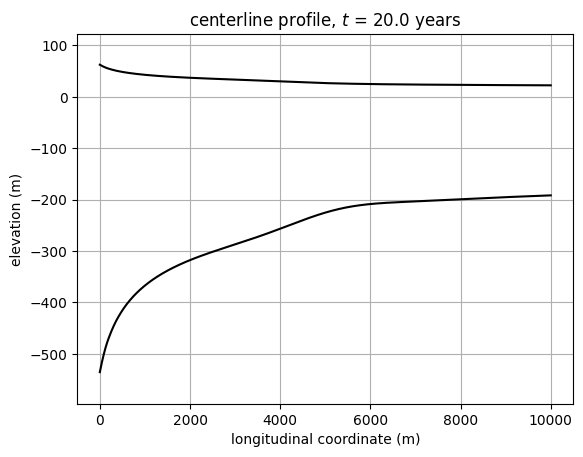

In [6]:
u, H, s, b = u0.copy(deepcopy=True), H0.copy(deepcopy=True), s0.copy(deepcopy=True), b0.copy(deepcopy=True) #initialize
os.chdir('/home/sermilik/firedrake_stuff/figures/flow_flexure') #for saving figures
X = np.array([(k, Ly/2) for k in range (Lx+1)]) #along-flow line for getting geometry profiles

#plot and save the initial surface/basal profiles along the line "X"
s_profile = np.array(s.at(X, tolerance = 1e-10))
b_profile = np.array(b.at(X, tolerance = 1e-10))
plt.figure()
plt.title('centerline profile, $t$ = 0 years')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('elevation (m)')
plt.ylim(int(-ϱ*H_gl - H_gl/10), int((1 - ϱ)*H_gl + H_gl/10))
plt.plot(s_profile, color='k')
plt.plot(b_profile, color='k')
plt.grid()
plt.savefig('iteration_0')
plt.close()

for step in tqdm.trange(num_timesteps):
    
    #############################
    #############################
    ### get velocity solution ###
    #############################
    #############################
    
    u = solver.diagnostic_solve(velocity = u, side_friction = C0, thickness = H, base = b, fluidity = A)
    
    ##################################
    ##################################
    ### dynamically thin the shelf ###
    ##################################
    ##################################
    
    s = solver.prognostic_solve(Δt, thickness = s, velocity = u, #lower the surface 
                           thickness_inflow = Constant((1 - ϱ)*H_gl), accumulation = Constant(0))
    
    b = solver.prognostic_solve(Δt, thickness = b, velocity = u, #raise the base
                           thickness_inflow = Constant(-ϱ*H_gl), accumulation = Constant(0))
    H = project(s - b, Q2)

    s_ = project(s, Q1) #project surface elevation over Argyris elements
    b_ = project(b, Q1) #and basal elevation
    H_ = project(s_ - b_, Q1) #and total thickness

    ν = icepack.models.viscosity.viscosity_depth_averaged(velocity = u, thickness = H, fluidity = A)*1e6 #ν in Pa*years
    
    ######################
    ######################
    ### flex the shelf ###
    ######################
    ######################

    h_ab = s_ + B*Δt + η*Δt - (1 - ϱ)*H_ #this will be the height above buoyancy once η is known

    #force flexure with surface mass balance (see Eq. 57a and 57c of MacAyeal et al. 2021)
    f = conditional(h_ab < 0, #if height above buoyancy is negative after flexing:
                    -ρ_w*g*h_ab, #f acts upward via buoyancy
                    -ρ_i*g*h_ab) #else: f acts downward via gravity
    
    # #additionally force flexure with the velocity field, as in Eq. 57e 
    # ux, uy = project(u[0], Q1), project(u[1], Q1) #velocity components in m/s
    # f += H_*(4*ν*grad(ux)[0] + 2*ν*grad(uy)[0] - 1/2*ρ_i*g*H_)*ddη[0, 0]*Δt #Eq. 57e: ice shelf flow contribution 
    # f += H_*(ν*grad(ux)[1] + ν*grad(uy)[0])*ddη[0, 1]*Δt #Eq. 57e continued
    # f += H_*(2*ν*grad(ux)[0] + 4*ν*grad(uy)[1] - 1/2*ρ_i*g*H_)*ddη[1, 1]*Δt #Eq. 57e continued

    L = 1/6*ν*H**3*inner(ddη, ddw)*dx + 1/6*ν*H**3*Δη*Δw*dx - f*w*dx
    L += 0.5*α**2*η*w*ds(1) #constrain η = 0 on the upstream boundary 1 via the penalty method
    L += 0.5*α**2*η*w*ds(2) #η = 0 on the downstream boundary via the penalty method

    solve(L == 0, η)

    #######################
    #######################
    ### adjust geometry ###
    #######################
    #######################
    
    b = project(b + η*Δt, Q2) #b is modified by the deflection
    s = project(s + B*Δt + η*Δt, Q2) #s is modified by deflection and surface mass balance 
    H = project(s - b, Q2) #in either case, H = s - b

    
    #################################################
    #################################################
    ### make sure nothing has gone horribly wrong ###
    #################################################
    #################################################
    
    #if we've imposed too much surface melt, the surface may dip below the waterline
    #this breaks the mass conservation equations
    
    s_values = s.vector().get_local()
    if not np.all(s_values > 0): #if s < 0 anywhere:
        print('the surface went underwater! that sucks!')
        break
        
    #################
    #################
    ### save figs ###
    #################
    #################
    
    #at each step, save plots of the surface and basal elevation profiles along "X"
    s_profile = np.array(s.at(X, tolerance = 1e-10))
    b_profile = np.array(b.at(X, tolerance = 1e-10))
    plt.figure()
    plt.title('centerline profile, $t$ = {:.1f} years'.format(step*Δt + Δt))
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('elevation (m)')
    plt.ylim(int(-ϱ*H_gl) - H_gl/10, int((1 - ϱ)*H_gl + H_gl/10))
    plt.plot(s_profile, color='k')
    plt.plot(b_profile, color='k')
    plt.grid()
    plt.savefig('iteration_{}'.format(step + 1))
    if step < num_timesteps - 1:
        plt.close() #save all plots but only show the last iteration

## Plot results

Notice that, in steady state, the surface lowering due to melt is balanced by the restorative upward creep. This means that, although the steady-state height above flotation is locally nonzero, it no longer changes from time step to time step. 

bulk height above buoyancy: 0.003 meters


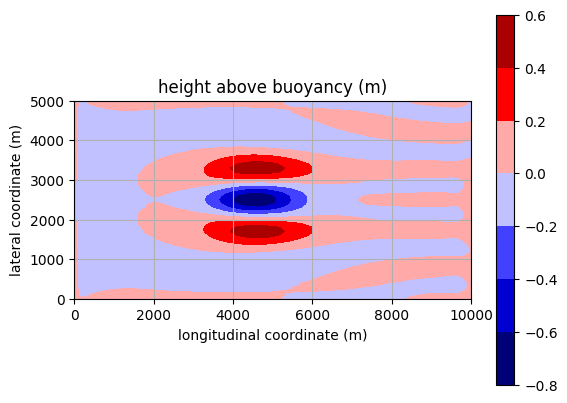

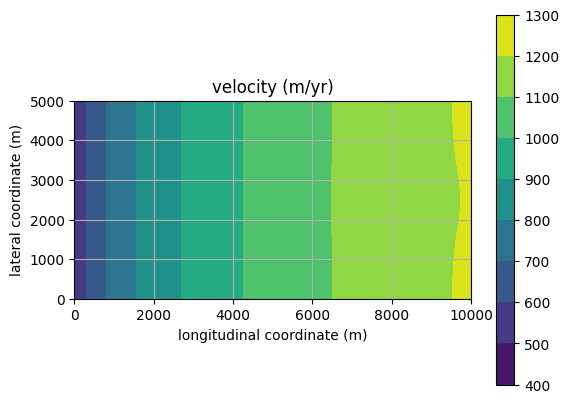

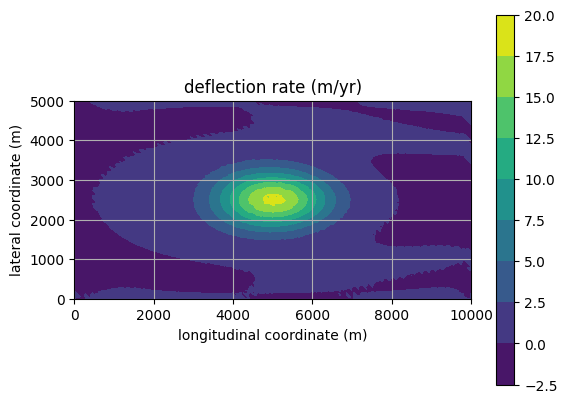

In [7]:
h_ab = project(h_ab, Q2) #local height above buoyancy
mean_hab = np.mean(h_ab.vector().get_local()) #calculate the bulk height above buoyancy across the entire shelf
print('bulk height above buoyancy: {:.3f} meters'.format(mean_hab))

fig, ax = plt.subplots() 
ax.set_aspect('equal')
plt.title('height above buoyancy (m)')
norm = colors.TwoSlopeNorm(vcenter = 0)
elev_plot = tricontourf(h_ab, axes=ax, norm = norm, cmap = 'seismic')
plt.colorbar(elev_plot)
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()
plt.show()

fig, ax = plt.subplots() 
ax.set_aspect('equal')
plt.title('velocity (m/yr)')
vel_plot = tricontourf(u, axes=ax)
plt.colorbar(vel_plot)
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()
plt.show()

fig, ax = plt.subplots() 
ax.set_aspect('equal')
plt.title('deflection rate (m/yr)')
vel_plot = tricontourf(project(η, Q1), axes=ax)
plt.colorbar(vel_plot)
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()
plt.show()

## Postprocessing

We can calculate the depth-integrated deviatoric stresses that arise via the flow and flexure field by applying Eq. 14 of MacAyeal et al. (See also the final cell of the [viscous Kirchhoff plate notebook](https://github.com/chrismiele/weird_flex/blob/main/2_kirchhoff_plate_viscous.ipynb).) 

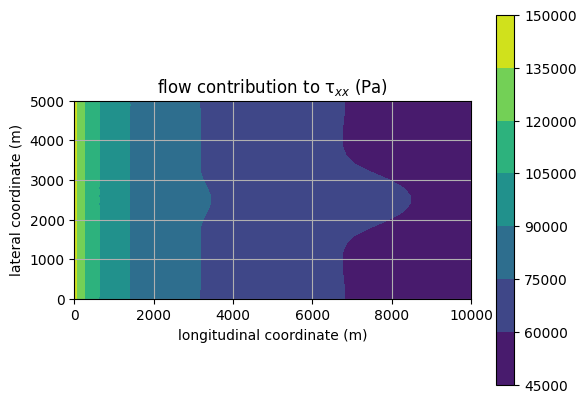

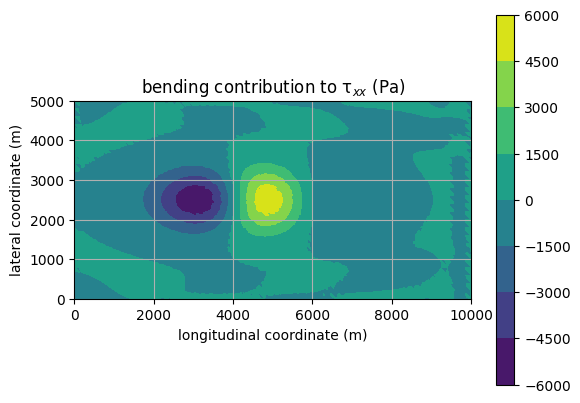

In [8]:
########################
########################
### viscous stresses ###
########################
########################

ε = Function(S)
ε.project(sym(grad(u)))
τ = deviatoric_stress(strain_rate = ε)
τxx = project(τ[0, 0], Q2)

fig, ax = plt.subplots() 
ax.set_aspect('equal')
plt.title('flow contribution to τ$_{xx}$ (Pa)')
stress_plot = tricontourf(τxx, axes=ax)
plt.colorbar(stress_plot)
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()
plt.show()

########################
########################
### elastic stresses ###
########################
########################

τ_bending = -2*ν*H/2*ddη #the bending part of τ evaluated at the surface of the plate
τxx_bending = project(τ_bending[0, 0], Q1) #the bending part of τ_xx evaluated at the surface of the plate 

fig, ax = plt.subplots() 
ax.set_aspect('equal')
plt.title('bending contribution to τ$_{xx}$ (Pa)')
stress_plot = tricontourf(τxx_bending, axes=ax)
plt.colorbar(stress_plot)
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()
plt.show()

## Which load contributions can we neglect?

Investigate the relative importance of different load contributions in Step 3 (solving the flexure equations). Below, ```f1``` will be the load contribution from the surface mass balance, as $-\rho_wg\dot{B}\Delta t$, and ```f2``` will be the load contribution from the velocity field (Eq. 57e). ```f2``` usually ends up being about an order of magnitude smaller than ```f1```, and it seems to become less important as the time step is refined, so it can probably be safely excluded from the workflow above?

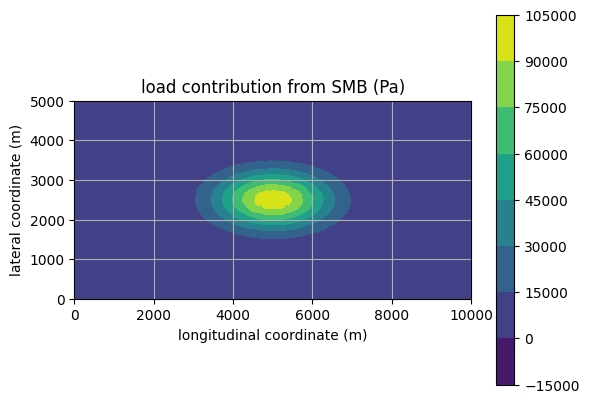

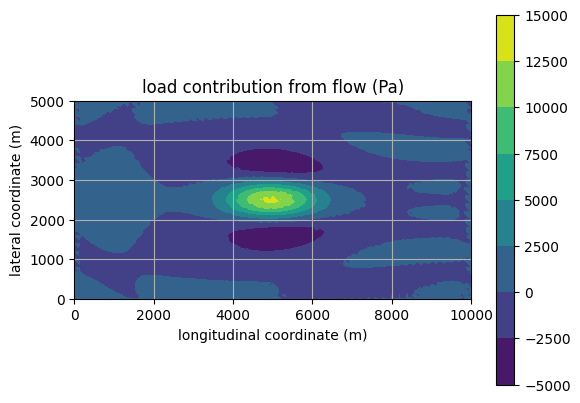

In [9]:
#load contribution from SMB:
f1 = project(conditional(B*Δt < 0, -ρ_w*g*B*Δt, -ρ_i*g*B*Δt), Q1)

#load contribution from flow:
ux, uy = project(u[0], Q1), project(u[1], Q1)
f2 = H_*(4*ν*grad(ux)[0] + 2*ν*grad(uy)[0] - 1/2*ρ_i*g*H_)*ddη[0, 0]*Δt #Eq. 57e: ice shelf flow contribution 
f2 += H_*(ν*grad(ux)[1] + ν*grad(uy)[0])*ddη[0, 1]*Δt #Eq. 57e continued
f2 += H_*(2*ν*grad(ux)[0] + 4*ν*grad(uy)[1] - 1/2*ρ_i*g*H_)*ddη[1, 1]*Δt #Eq. 57e continued
f2 = project(f2, Q1)

fig, ax = plt.subplots() 
ax.set_aspect('equal')
plt.title('load contribution from SMB (Pa)')
elev_plot = tricontourf(f1, axes=ax)
plt.colorbar(elev_plot)
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()
plt.show()

fig, ax = plt.subplots() 
ax.set_aspect('equal')
plt.title('load contribution from flow (Pa)')
vel_plot = tricontourf(f2, axes=ax)
plt.colorbar(vel_plot)
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()
plt.show()